# For Issue 1279 | 311 API Data Cleaning & Exploratory Analysis
---
Identify addresses or small areas that could benefit from more signage, increased community assistance, or other actions

# Conclusions
---

# Table of Contents
---
### [Package Imports](#Imports-and-Formatting)
### [API & Data Imports](#LA-311-Raw-Data-Imports)
### [Data Cleaning](#Cleaning)
### [Exploratory Data Analysis](#Explore)
> #### [All Requests in Dataset](#All-Requests)

> #### [Addresses w/ >= 2 Requests in Dataset](#>=2-Requests)

> #### [Addresses w/ >= 5 Requests in Dataset](#>=5-Requests)
### [Timeseries Exploratory Data Analysis](#Timeseries-EDA)

# Imports and Formatting
-----

In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

## LA 311 Raw Data Imports
-----
[API Source](https://data.lacity.org/City-Infrastructure-Service-Requests/MyLA311-Service-Request-Data-2022/i5ke-k6by) | [Documentation](https://dev.socrata.com/foundry/data.lacity.org/i5ke-k6by) | [Hack for LA API File](https://github.com/hackforla/311-data/blob/dev/server/utils/get_request_data_csv.py)

In [2]:
# preserving code for just in case; API pull for most recent 1000 311 requests
'''
url = "https://data.lacity.org/resource/i5ke-k6by.json"
req = requests.get(url)
print(f'Status: {req.status_code}')

json_311 = req.json()
df_311_1000 = json_normalize(json_311)
'''

'\nurl = "https://data.lacity.org/resource/i5ke-k6by.json"\nreq = requests.get(url)\nprint(f\'Status: {req.status_code}\')\n\njson_311 = req.json()\ndf_311_1000 = json_normalize(json_311)\n'

In [3]:
# CMD LINE: python get_311_request_data_csv.py "2021-10-01" "2022-10-01"
df_311_raw = pd.read_csv('./data/01Oct21_01Oct22_api.csv')
df_311 = df_311_raw.copy()

In [4]:
print(df_311.shape)
df_311.head()

(1096525, 16)


,Unnamed: 0,requestId,srnumber,councilId,councilName,typeId,typeName,agencyId,agencyName,sourceId,sourceName,createdDate,closedDate,address,latitude,longitude
0,0,8610592,1-2079512481,64,Pacoima,4,Bulky Items,3,Sanitation Bureau,8,Phone Call,2021-10-01T00:01:14,2021-10-08T09:24:53,"11614 N HERRICK AVE, 91340",34.281312,-118.425453
1,1,8610569,1-2079516251,64,Pacoima,5,Electronic Waste,3,Sanitation Bureau,8,Phone Call,2021-10-01T00:02:19,2021-10-08T13:36:33,"11614 N HERRICK AVE, 91340",34.281312,-118.425453
2,2,8610575,1-2079512561,72,Sherman Oaks,4,Bulky Items,3,Sanitation Bureau,8,Phone Call,2021-10-01T00:03:11,2021-10-13T12:31:58,"4539 N VISTA DEL MONTE AVE, 91403",34.154158,-118.450025
3,3,8612855,1-2079516331,38,Historic Cultural North,6,Illegal Dumping,3,Sanitation Bureau,3,Email,2021-10-01T00:04:14,2021-10-05T14:25:02,"918 W COLLEGE ST, 90012",34.066466,-118.245113
4,4,8610587,1-2079516401,64,Pacoima,7,Metal/Appliances,3,Sanitation Bureau,8,Phone Call,2021-10-01T00:05:25,2021-10-08T14:16:32,"11614 N HERRICK AVE, 91340",34.281312,-118.425453


# Cleaning
---

## Arrange Columns

In [5]:
# API pull for most recent 1000 311 requests
'''
df_311_1000 = df_311_1000[['servicedate', 'requesttype', 'latitude', 'longitude',  
                'address', 'zipcode', 'nc', 'ncname', 'requestsource', 'assignto', 'owner',
                'cd', 'cdmember', 'apc', 'status']]
'''

"\ndf_311_1000 = df_311_1000[['servicedate', 'requesttype', 'latitude', 'longitude',  \n                'address', 'zipcode', 'nc', 'ncname', 'requestsource', 'assignto', 'owner',\n                'cd', 'cdmember', 'apc', 'status']]\n"

In [6]:
print(df_311.shape)
# df_311.head()

(1096525, 16)


In [7]:
df_311.columns

Index(['Unnamed: 0', 'requestId', 'srnumber', 'councilId', 'councilName',
       'typeId', 'typeName', 'agencyId', 'agencyName', 'sourceId',
       'sourceName', 'createdDate', 'closedDate', 'address', 'latitude',
       'longitude'],
      dtype='object')

In [8]:
df_311 = df_311[['requestId', 'createdDate', 'closedDate', 'typeId', 'typeName', 'address', 'latitude',
       'longitude', 'agencyId', 'agencyName', 'sourceId', 'srnumber', 'sourceName', 'councilId', 'councilName']]

## Check/Handle Nulls

In [9]:
df_311.shape

(1096525, 15)

In [10]:
(df_311.isnull().sum().sum())/len(df_311)

0.049535578304188234

In [11]:
df_311.dropna(inplace = True)

In [12]:
df_311.shape

(1042208, 15)

## Check/Handle Data Types

In [13]:
df_311.dtypes

requestId        int64
createdDate     object
closedDate      object
typeId           int64
typeName        object
address         object
latitude       float64
longitude      float64
agencyId         int64
agencyName      object
sourceId         int64
srnumber        object
sourceName      object
councilId        int64
councilName     object
dtype: object

In [14]:
# Dates to datetime
df_311['createdDate'] = pd.to_datetime(df_311['createdDate'])
df_311['closedDate'] = pd.to_datetime(df_311['closedDate'])

# councilID to object
df_311['councilID'] = df_311['councilId'].apply(lambda x: int(x))

# zip lat/lon
df_311['lat_lon'] = [(lat, lon) for lat, lon in zip(df_311['latitude'], df_311['longitude'])]
df_311 = df_311[['requestId', 'createdDate', 'closedDate', 'typeId', 'typeName', 'address', 'lat_lon', 'latitude',
       'longitude', 'agencyId', 'agencyName', 'sourceId', 'srnumber', 'sourceName', 'councilId', 'councilName']]

In [15]:
df_311.dtypes

requestId               int64
createdDate    datetime64[ns]
closedDate     datetime64[ns]
typeId                  int64
typeName               object
address                object
lat_lon                object
latitude              float64
longitude             float64
agencyId                int64
agencyName             object
sourceId                int64
srnumber               object
sourceName             object
councilId               int64
councilName            object
dtype: object

In [16]:
print(df_311.shape)
df_311.head()

(1042208, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima
2,8610575,2021-10-01 00:03:11,2021-10-13 12:31:58,4,Bulky Items,"4539 N VISTA DEL MONTE AVE, 91403","(34.1541582469, -118.450024901)",34.154158,-118.450025,3,Sanitation Bureau,8,1-2079512561,Phone Call,72,Sherman Oaks
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012","(34.066466398, -118.245112635)",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima


In [17]:
df_311.to_csv('./data/clean_01Oct21_01Oct22_api.csv', index = False)

# Explore
---

## All Requests

Dates are only for 10/01/2021-10/01/2022

In [18]:
df_311.describe(include = 'all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
requestId,1042208.0,NaN,NaN,NaN,NaT,NaT,9662942.524817,601992.305528,8610569.0,9144644.5,9659138.5,10180140.75,10747580.0
createdDate,1042208,921751,2022-09-16 13:14:10,10,2021-10-01 00:01:14,2022-10-01 23:44:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
closedDate,1042208,1010282,2021-11-15 00:00:00,72,2012-12-07 00:00:00,2022-12-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
typeId,1042208.0,NaN,NaN,NaN,NaT,NaT,3.80268,2.139087,1.0,2.0,4.0,4.0,12.0
typeName,1042208,12,Bulky Items,490106,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,1042208,364214,"1901 E 6TH ST, 90033",575,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat_lon,1042208,374232,"(34.0402243064, -118.219759107)",575,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,1042208.0,NaN,NaN,NaN,NaT,NaT,34.090439,0.122376,33.705737,34.020332,34.07904,34.19295,34.334335
longitude,1042208.0,NaN,NaN,NaN,NaT,NaT,-118.36399,0.110621,-118.667817,-118.443194,-118.335812,-118.277894,-118.155779
agencyId,1042208.0,NaN,NaN,NaN,NaT,NaT,3.245523,0.575134,1.0,3.0,3.0,4.0,12.0


In [19]:
# count of requests by type and neighborhood council
type_nc_ct = df_311.groupby(['typeName', 'councilName'])['requestId'].agg('count').reset_index(name = 'request_count')
type_nc_ct.sort_values(by = 'request_count', ascending = False).head(20)

,typeName,councilName,request_count
377,Graffiti,Boyle Heights,16795
447,Graffiti,South Central,14875
386,Graffiti,Downtown Los Angeles,12191
183,Bulky Items,Van Nuys,12127
120,Bulky Items,Empowerment Congress Southeast,10519
179,Bulky Items,Sylmar,10312
198,Bulky Items,Woodland Hills-Warner Center,9798
171,Bulky Items,Reseda,9495
172,Bulky Items,Sherman Oaks,9375
388,Graffiti,East Hollywood,8849


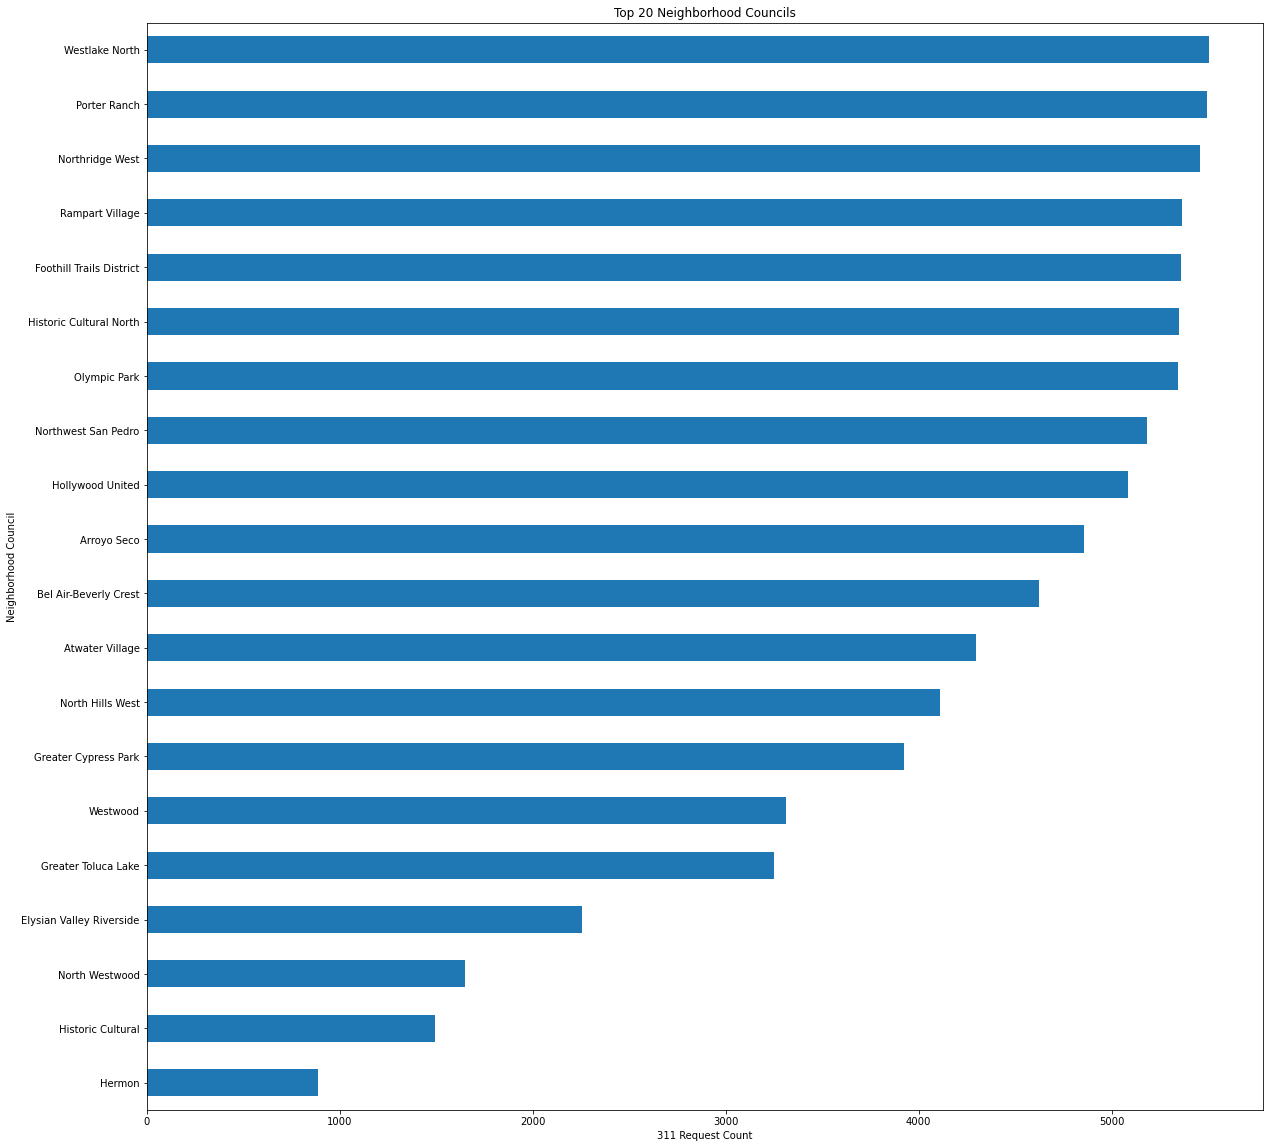

In [20]:
# Bar chart for type of request counts for all requests
plt.figure(figsize = (20,20))
df_311['councilName'].value_counts().sort_values(ascending = True).head(20).plot(kind = 'barh')
plt.title('Top 20 Neighborhood Councils')
plt.ylabel('Neighborhood Council')
plt.xlabel('311 Request Count')
plt.plot();

In [21]:
for nc in sorted(df_311['councilName'].unique()):
    print(f'{nc}: {(len(df_311[df_311["councilName"] == nc]) / len(df_311))*100}% of whole dataset')
    print()

Arleta: 1.0128496422978905% of whole dataset

Arroyo Seco: 0.46602981362645457% of whole dataset

Atwater Village: 0.4125855875218767% of whole dataset

Bel Air-Beverly Crest: 0.44348153151770087% of whole dataset

Boyle Heights: 2.9575670115754247% of whole dataset

CANNDU: 1.375061408087445% of whole dataset

Canoga Park: 1.0445131873867788% of whole dataset

Central Alameda: 0.7989767877429457% of whole dataset

Central Hollywood: 0.530220455033928% of whole dataset

Central San Pedro: 1.0116022905216617% of whole dataset

Chatsworth: 1.075792931929135% of whole dataset

Coastal San Pedro: 0.7686565445669195% of whole dataset

Del Rey: 0.6927599864902207% of whole dataset

Downtown Los Angeles: 1.7470600878135651% of whole dataset

Eagle Rock: 0.7463001627314317% of whole dataset

East Hollywood: 1.8132656820903315% of whole dataset

Echo Park: 1.6145529491233996% of whole dataset

Elysian Valley Riverside: 0.21646350824403573% of whole dataset

Empowerment Congress Central: 1.41181

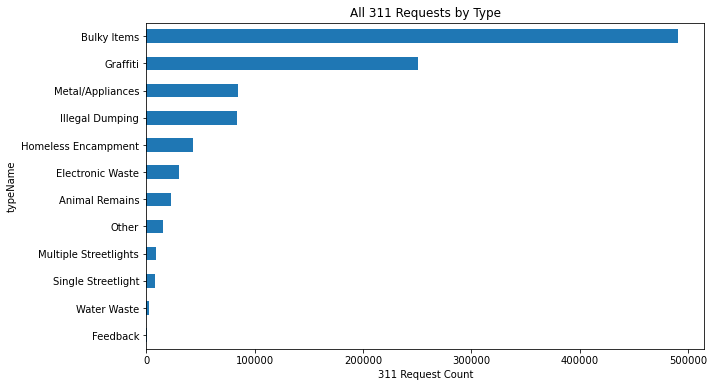

In [22]:
# Bar chart for type of request counts for all requests
plt.figure(figsize = (10,6))
df_311['typeName'].value_counts().sort_values(ascending = True).plot(kind = 'barh')
plt.title('All 311 Requests by Type')
plt.ylabel('typeName')
plt.xlabel('311 Request Count')
plt.plot();

In [23]:
for value in sorted(df_311['typeName'].unique()):
    print(f'{value}: {(len(df_311[df_311["typeName"] == value]) / len(df_311))*100}% of whole dataset')
    print()

Animal Remains: 2.1659783843532194% of whole dataset

Bulky Items: 47.025737664650435% of whole dataset

Electronic Waste: 2.945957045042832% of whole dataset

Feedback: 0.026961988393871473% of whole dataset

Graffiti: 24.09164005649544% of whole dataset

Homeless Encampment: 4.16538733151156% of whole dataset

Illegal Dumping: 8.029395283858884% of whole dataset

Metal/Appliances: 8.164876876784673% of whole dataset

Multiple Streetlights: 0.8527088642574226% of whole dataset

Other: 1.4536445699898677% of whole dataset

Single Streetlight: 0.7903412754459762% of whole dataset

Water Waste: 0.2873706592158187% of whole dataset



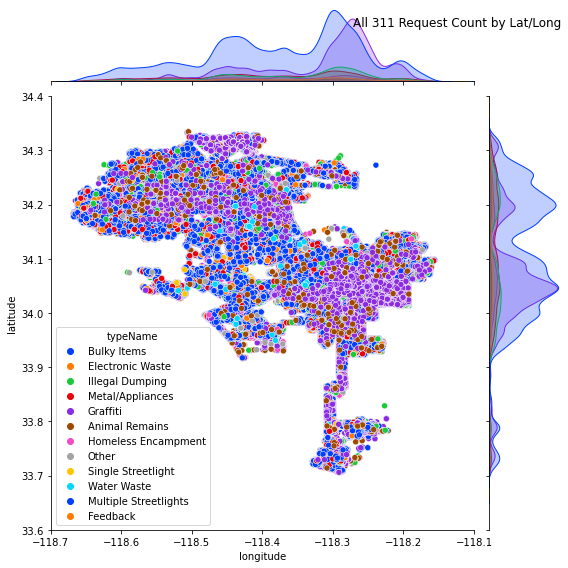

In [24]:
# type by location
sns.jointplot(x = df_311['longitude'], y = df_311['latitude'], hue = df_311['typeName'], 
              kind='scatter', color = 'green', height = 8, palette = 'bright', 
              xlim = (-118.7, -118.1), ylim = (33.6, 34.4)
             )
plt.title('All 311 Request Count by Lat/Long', pad = 70, loc = 'right')
plt.show();

## >=2 Requests

In [25]:
by_address = df_311.groupby(['typeName', 'latitude', 'longitude', 'councilId', 
                             'councilName'])['address'].value_counts().sort_values(ascending = False).reset_index(name='count')
grt_eq_2_ct = by_address[by_address['count'] >= 2]
print(grt_eq_2_ct.size)
grt_eq_2_ct.head()

1286215


,typeName,latitude,longitude,councilId,councilName,address,count
0,Graffiti,34.040224,-118.219759,5,Boyle Heights,"1901 E 6TH ST, 90033",575
1,Graffiti,34.297026,-118.419005,79,Sylmar,"BRAND BLVD AT FOOTHILL BLVD, 91340",421
2,Homeless Encampment,34.225457,-118.366056,77,Sun Valley Area,"8601 N SUNLAND BLVD, 91352",261
3,Graffiti,34.040055,-118.219868,5,Boyle Heights,"1900 E 6TH ST, 90033",234
4,Graffiti,34.296286,-118.455561,79,Sylmar,ASTORIA ST AT SAN FERNANDO ROAD SOUTHWEST RDWY...,205


In [26]:
grt_eq_2_ct.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
typeName,183745,12,Bulky Items,102576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,183745.0,NaN,NaN,NaN,34.08987,0.123331,33.706052,34.01878,34.079963,34.193178,34.334335
longitude,183745.0,NaN,NaN,NaN,-118.365509,0.110721,-118.667806,-118.443639,-118.340945,-118.280065,-118.155779
councilId,183745.0,NaN,NaN,NaN,51.03137,30.075334,0.0,22.0,52.0,78.0,99.0
councilName,183745,100,Boyle Heights,5080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,183745,149695,"4705 N WHITSETT AVE, 91604",10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,183745.0,NaN,NaN,NaN,3.708471,4.557405,2.0,2.0,2.0,4.0,575.0


In [27]:
# https://stackoverflow.com/questions/32918506/pandas-how-to-filter-dataframe-for-duplicate-items-that-occur-at-least-n-times
grt_eq_2_df = df_311[df_311['address'].isin(df_311['address'].value_counts()[df_311['address'].value_counts()>=2].index)]
print(grt_eq_2_df.shape)
grt_eq_2_df.head()

(871896, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012","(34.066466398, -118.245112635)",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima
5,8610607,2021-10-01 00:10:13,2021-10-20 03:57:42,6,Illegal Dumping,"PICO BLVD AT MILITARY AVE, 90064","(34.0380363243, -118.43288384)",34.038036,-118.432884,3,Sanitation Bureau,8,1-2079516601,Phone Call,93,Westside


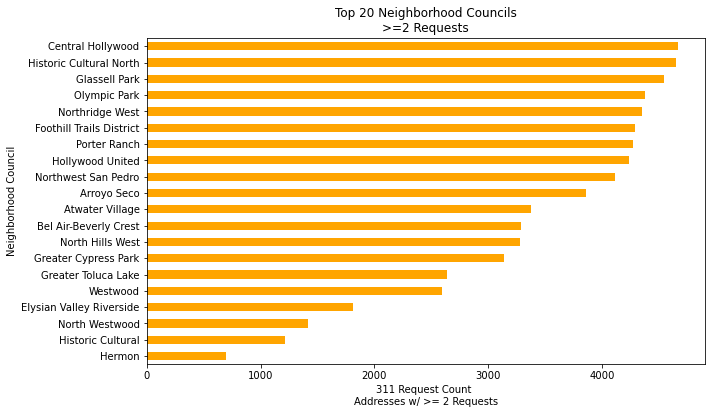

In [28]:
# Bar chart councilName for Neighborhood Councils with >=2 requests; top 20
plt.figure(figsize = (10,6))
grt_eq_2_df['councilName'].value_counts().sort_values(ascending = True).head(20).plot(kind = 'barh', color = 'orange')
plt.title('Top 20 Neighborhood Councils\n>=2 Requests')
plt.ylabel('Neighborhood Council')
plt.xlabel('311 Request Count \nAddresses w/ >= 2 Requests')
plt.plot();

In [29]:
# count of requests by type and neighborhood council for addresses with >= 2 requests
grt_eq_2_type_nc_ct = grt_eq_2_df.groupby(['typeName', 'councilName'])['requestId'].agg('count').reset_index(name = 'request_count')
grt_eq_2_type_nc_ct.sort_values(by = 'request_count', ascending = False).head(20)

,typeName,councilName,request_count
369,Graffiti,Boyle Heights,14564
439,Graffiti,South Central,13837
183,Bulky Items,Van Nuys,10535
378,Graffiti,Downtown Los Angeles,10300
120,Bulky Items,Empowerment Congress Southeast,8832
179,Bulky Items,Sylmar,8605
380,Graffiti,East Hollywood,8134
171,Bulky Items,Reseda,8041
444,Graffiti,Sylmar,7944
196,Bulky Items,Wilshire Center - Koreatown,7887


In [30]:
grt_eq_2_type_nc_ct.sort_values(by = 'request_count', ascending = False).tail(20)

,typeName,councilName,request_count
342,Feedback,Palms,1
338,Feedback,North Westwood,1
1082,Water Waste,Empowerment Congress Central,1
335,Feedback,No council,1
354,Feedback,Tarzana,1
356,Feedback,Valley Village,1
1099,Water Waste,Hermon,1
329,Feedback,Lake Balboa,1
328,Feedback,LA-32,1
325,Feedback,Historic Cultural North,1


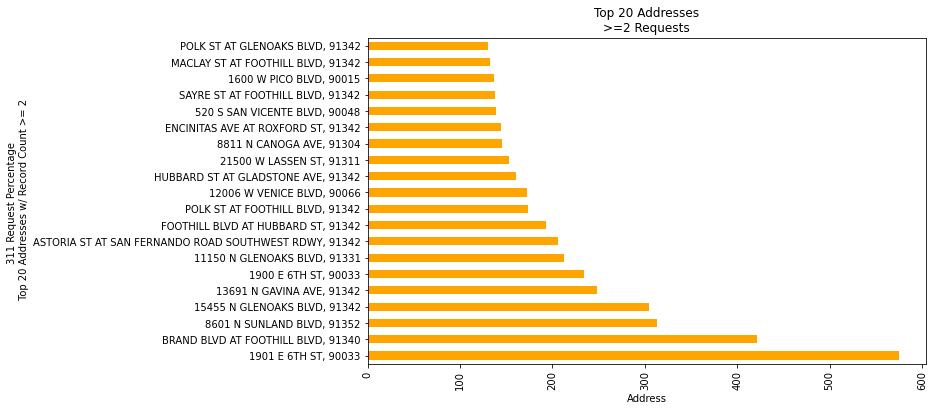

In [31]:
# Addresses with >=2 requests
plt.figure(figsize = (10, 6))
grt_eq_2_df['address'].value_counts().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'orange')
plt.title('Top 20 Addresses\n>=2 Requests')
plt.xlabel('Address')
plt.ylabel('311 Request Percentage \n Top 20 Addresses w/ Record Count >= 2')
plt.xticks(rotation=90);

In [32]:
# count of requests by type and address for addresses with >= 2 requests
grt_eq_2_type_add_ct = grt_eq_2_df.groupby(['typeName', 'address'])['requestId'].agg('count').reset_index(name = 'request_count')
grt_eq_2_type_add_ct.sort_values(by = 'request_count', ascending = False).head(20)

,typeName,address,request_count
198121,Graffiti,"1901 E 6TH ST, 90033",575
230490,Graffiti,"BRAND BLVD AT FOOTHILL BLVD, 91340",421
245909,Homeless Encampment,"8601 N SUNLAND BLVD, 91352",263
198033,Graffiti,"1900 E 6TH ST, 90033",234
230225,Graffiti,ASTORIA ST AT SAN FERNANDO ROAD SOUTHWEST RDWY...,205
231241,Graffiti,"FOOTHILL BLVD AT HUBBARD ST, 91342",188
51485,Bulky Items,"15455 N GLENOAKS BLVD, 91342",184
232803,Graffiti,"POLK ST AT FOOTHILL BLVD, 91342",171
231676,Graffiti,"HUBBARD ST AT GLADSTONE AVE, 91342",161
20644,Bulky Items,"11150 N GLENOAKS BLVD, 91331",160


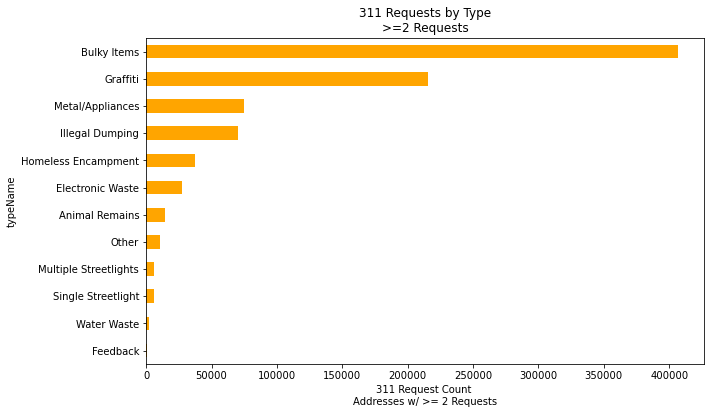

In [33]:
# Bar chart types of requests for address with >=2 requests
plt.figure(figsize = (10,6))
grt_eq_2_df['typeName'].value_counts().sort_values(ascending = True).plot(kind = 'barh', color = 'orange')
plt.title('311 Requests by Type\n>=2 Requests')
plt.ylabel('typeName')
plt.xlabel('311 Request Count \nAddresses w/ >= 2 Requests')
plt.plot();

In [34]:
for value in sorted(grt_eq_2_df['typeName'].unique()):
    print(f'{value}: {(len(grt_eq_2_df[grt_eq_2_df["typeName"] == value]) / len(grt_eq_2_df))*100}% of >=2 dataset')
    print()

Animal Remains: 1.61831227577601% of >=2 dataset

Bulky Items: 46.61668364116821% of >=2 dataset

Electronic Waste: 3.1625331461550457% of >=2 dataset

Feedback: 0.026493985521208952% of >=2 dataset

Graffiti: 24.742859240092855% of >=2 dataset

Homeless Encampment: 4.314849477460615% of >=2 dataset

Illegal Dumping: 8.013799810986631% of >=2 dataset

Metal/Appliances: 8.58198684246745% of >=2 dataset

Multiple Streetlights: 0.7246277078917669% of >=2 dataset

Other: 1.2432675456705846% of >=2 dataset

Single Streetlight: 0.6942341747180857% of >=2 dataset

Water Waste: 0.26035215209153384% of >=2 dataset



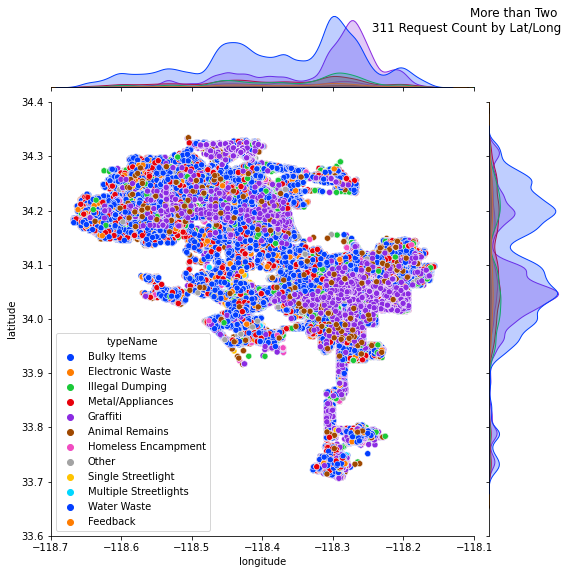

In [35]:
# Address with >=2 requests
sns.jointplot(x = grt_eq_2_df['longitude'], y = grt_eq_2_df['latitude'], hue = grt_eq_2_df['typeName'],
              kind='scatter', height = 8, palette = 'bright', 
              xlim = (-118.7, -118.1), ylim = (33.6, 34.4)
             )
plt.title('More than Two \n 311 Request Count by Lat/Long', pad = 70, loc = 'right')
plt.show();

## >=5 Requests

In [36]:
by_address = df_311.groupby(['typeName', 'latitude', 'longitude', 'councilId', 'councilName'])['address'].value_counts().sort_values(ascending = False).reset_index(name='count')
grt_eq_5_ct = by_address[by_address['count'] >= 5]

In [37]:
grt_eq_5_ct.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
typeName,34058,12,Bulky Items,17896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,34058.0,NaN,NaN,NaN,34.089615,0.119518,33.706052,34.025398,34.076688,34.190088,34.334335
longitude,34058.0,NaN,NaN,NaN,-118.359563,0.108301,-118.667806,-118.439985,-118.323623,-118.276522,-118.155969
councilId,34058.0,NaN,NaN,NaN,51.453139,30.071169,0.0,22.0,52.0,78.0,99.0
councilName,34058,100,Boyle Heights,1099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,34058,31088,"12001 W FOOTHILL BLVD, 91342",7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,34058.0,NaN,NaN,NaN,9.057226,8.646733,5.0,5.0,7.0,10.0,575.0


In [38]:
# https://stackoverflow.com/questions/32918506/pandas-how-to-filter-dataframe-for-duplicate-items-that-occur-at-least-n-times
grt_eq_5_df = df_311[df_311['address'].isin(df_311['address'].value_counts()[df_311['address'].value_counts()>=5].index)]
print(grt_eq_5_df.shape)
grt_eq_5_df.head()

(503464, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012","(34.066466398, -118.245112635)",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima
5,8610607,2021-10-01 00:10:13,2021-10-20 03:57:42,6,Illegal Dumping,"PICO BLVD AT MILITARY AVE, 90064","(34.0380363243, -118.43288384)",34.038036,-118.432884,3,Sanitation Bureau,8,1-2079516601,Phone Call,93,Westside


In [39]:
# grt_eq_5_df.groupby(['councilName', 'typeName'])['requestId'].agg('count').reset_index(name = 'request_count').sort_values(by = 'request_count', ascending = False).head(20)

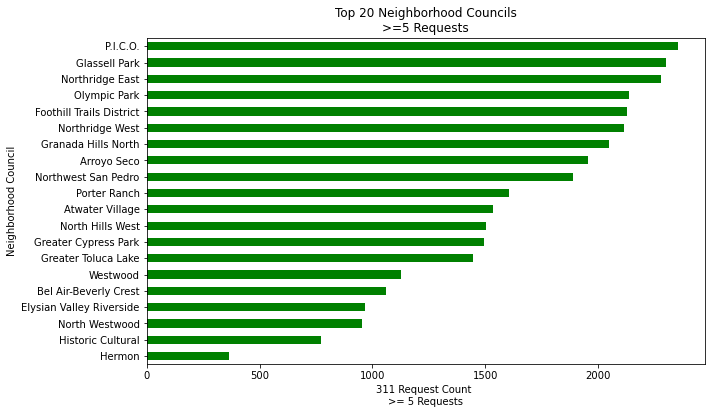

In [40]:
# Bar chart councilName for Neighborhood Councils with >=5 requests
plt.figure(figsize = (10,6))
grt_eq_5_df['councilName'].value_counts().sort_values(ascending = True).head(20).plot(kind = 'barh', color = 'green')
plt.title('Top 20 Neighborhood Councils\n>=5 Requests')
plt.ylabel('Neighborhood Council')
plt.xlabel('311 Request Count \n>= 5 Requests')
plt.plot();

In [41]:
# count of requests by type and neighborhood council for addresses with >= 5 requests
grt_eq_5_type_nc_ct = grt_eq_5_df.groupby(['typeName', 'councilName'])['requestId'].agg('count').reset_index(name = 'request_count')
grt_eq_5_type_nc_ct.sort_values(by = 'request_count', ascending = False).head(20)

,typeName,councilName,request_count
418,Graffiti,South Central,11799
348,Graffiti,Boyle Heights,10807
423,Graffiti,Sylmar,7048
183,Bulky Items,Van Nuys,7028
357,Graffiti,Downtown Los Angeles,6750
359,Graffiti,East Hollywood,6707
443,Graffiti,Zapata King,5930
196,Bulky Items,Wilshire Center - Koreatown,5865
412,Graffiti,Pico Union,5499
166,Bulky Items,Panorama City,4961


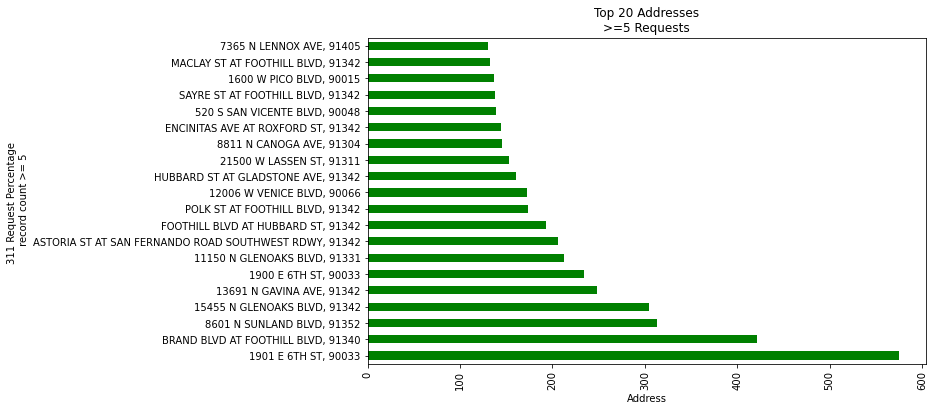

In [42]:
# Addresses with >=5 requests; top 20
plt.figure(figsize = (10,6))
grt_eq_5_df['address'].value_counts().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'green')
plt.title('Top 20 Addresses\n>=5 Requests')
plt.xlabel('Address')
plt.ylabel('311 Request Percentage \n record count >= 5')
plt.xticks(rotation=90);

In [43]:
# count of requests by type and address for addresses with >= 5 requests
grt_eq_5_type_add_ct = grt_eq_5_df.groupby(['typeName', 'address'])['requestId'].agg('count').reset_index(name = 'request_count')
grt_eq_5_type_add_ct.sort_values(by = 'request_count', ascending = False).head(20)

,typeName,address,request_count
62758,Graffiti,"1901 E 6TH ST, 90033",575
76177,Graffiti,"BRAND BLVD AT FOOTHILL BLVD, 91340",421
83390,Homeless Encampment,"8601 N SUNLAND BLVD, 91352",263
62720,Graffiti,"1900 E 6TH ST, 90033",234
76071,Graffiti,ASTORIA ST AT SAN FERNANDO ROAD SOUTHWEST RDWY...,205
76460,Graffiti,"FOOTHILL BLVD AT HUBBARD ST, 91342",188
15072,Bulky Items,"15455 N GLENOAKS BLVD, 91342",184
77033,Graffiti,"POLK ST AT FOOTHILL BLVD, 91342",171
76621,Graffiti,"HUBBARD ST AT GLADSTONE AVE, 91342",161
6222,Bulky Items,"11150 N GLENOAKS BLVD, 91331",160


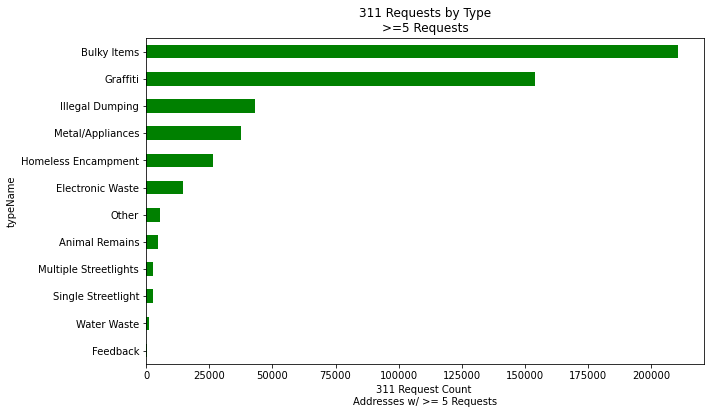

In [44]:
# Bar chart types of requests for address with >=5 requests
plt.figure(figsize = (10,6))
grt_eq_5_df['typeName'].value_counts().sort_values(ascending = True).plot(kind = 'barh', color = 'green')
plt.title('311 Requests by Type\n>=5 Requests')
plt.ylabel('typeName')
plt.xlabel('311 Request Count \nAddresses w/ >= 5 Requests')
plt.plot();

In [45]:
for value in sorted(grt_eq_5_df['typeName'].unique()):
    print(f'{value}: {(len(grt_eq_5_df[grt_eq_5_df["typeName"] == value]) / len(grt_eq_5_df))*100}% of >=5 dataset')
    print()

Animal Remains: 0.9631274530055774% of >=5 dataset

Bulky Items: 41.80934485881811% of >=5 dataset

Electronic Waste: 2.8711089571449% of >=5 dataset

Feedback: 0.03317019687604278% of >=5 dataset

Graffiti: 30.55094306643573% of >=5 dataset

Homeless Encampment: 5.294718192363307% of >=5 dataset

Illegal Dumping: 8.578369059158153% of >=5 dataset

Metal/Appliances: 7.435089698568318% of >=5 dataset

Multiple Streetlights: 0.5698520648944115% of >=5 dataset

Other: 1.0757472232374112% of >=5 dataset

Single Streetlight: 0.5658795862266219% of >=5 dataset

Water Waste: 0.25264964327141565% of >=5 dataset



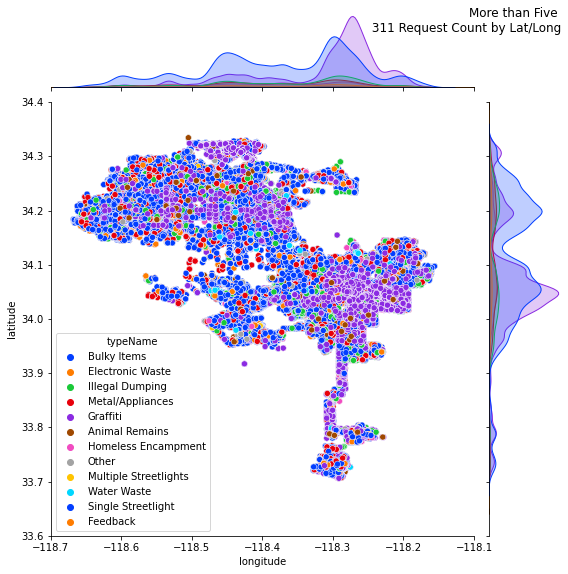

In [46]:
# Address with more than 5 requests
sns.jointplot(x = grt_eq_5_df['longitude'], y = grt_eq_5_df['latitude'], hue = grt_eq_5_df['typeName'],
              kind='scatter', height = 8, palette = 'bright', 
              xlim = (-118.7, -118.1), ylim = (33.6, 34.4)
             )
plt.title('More than Five \n 311 Request Count by Lat/Long', pad = 70, loc = 'right')
plt.show();

# Timeseries EDA
---

In [47]:
# Set Date to be in the index
df_311.set_index('createdDate', inplace = True)

# Sort the index# Sort the index
df_311.sort_index(inplace = True)

df_311.head()

,requestId,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
createdDate,,,,,,,,,,,,,,,
2021-10-01 00:01:14,8610592,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima
2021-10-01 00:02:19,8610569,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima
2021-10-01 00:03:11,8610575,2021-10-13 12:31:58,4,Bulky Items,"4539 N VISTA DEL MONTE AVE, 91403","(34.1541582469, -118.450024901)",34.154158,-118.450025,3,Sanitation Bureau,8,1-2079512561,Phone Call,72,Sherman Oaks
2021-10-01 00:04:14,8612855,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012","(34.066466398, -118.245112635)",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North
2021-10-01 00:05:25,8610587,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima


In [48]:
df_nc_ct = df_311.groupby(['createdDate','councilId'])['requestId'].agg('count').reset_index(name = 'request_ct')
df_nc_ct['nc_running_ct'] = df_nc_ct.groupby('councilId')['request_ct'].cumsum()
df_nc_ct.set_index('createdDate', inplace = True)
df_nc_ct.head()

,councilId,request_ct,nc_running_ct
createdDate,,,
2021-10-01 00:01:14,64,1,1
2021-10-01 00:02:19,64,1,2
2021-10-01 00:03:11,72,1,1
2021-10-01 00:04:14,38,1,1
2021-10-01 00:05:25,64,1,3


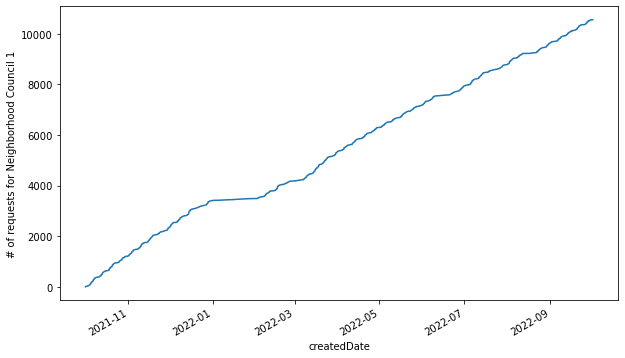

In [49]:
plt.figure(figsize = (10,6))
ts_plt = df_nc_ct[df_nc_ct['councilId'] == 1]
ts_plt['nc_running_ct'].plot()
plt.ylabel('# of requests for Neighborhood Council 1')
plt.plot();